In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/python/cpt-softano/code"

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 527 kB 4.2 MB/s 
     |████████████████████████████████| 133 kB 102.3 MB/s 
     |████████████████████████████████| 596 kB 89.6 MB/s 
     |████████████████████████████████| 952 kB 76.4 MB/s 
     |████████████████████████████████| 829 kB 102.3 MB/s 
     |████████████████████████████████| 397 kB 93.7 MB/s 
     |████████████████████████████████| 1.1 MB 71.3 MB/s 
     |████████████████████████████████| 271 kB 81.2 MB/s 
     |████████████████████████████████| 144 kB 76.2 MB/s 
     |████████████████████████████████| 94 kB 4.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=6c824a340ae9d1aa87916920b001790ed78ae3329d8ee3abc3b008514793cc66
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successf

### LSTMで学習を行う流れ
1. 特徴量選択
    * 相関が大きい変数を選択
    * 特徴量エンジニアリングはこのチュートリアルでは行わない
1. 学習に使う箇所の抽出
    * 正常と異常のバランスを揃えないと、正常としか出力できないモデルができてしまうため
    * 異常箇所の前後から抽出
1. LSTMモデル作成 pytorch lightningというライブラリを用いてNNの学習を行う。
    1. 学習するためのDatasetを作成
        1. (Batch,window,特徴量数)となるように
    1. LSTMモデルの定義
    1. 学習してmodelを保存
    

In [ ]:
import os
from pathlib import Path
import warnings
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.datamodule import LightningDataModule
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers.csv_logs import CSVLogger

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.nn as nn
import torch
from torch.optim import AdamW
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from datatable import (dt, f, join)
import gc
from glob import glob

import multiprocessing

import numpy as np
import pandas as pd
import logging

import random

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/python/cpt-softano/datal/train.csv")
train

,timestamp,host,Anomaly,process,"Active connections : (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source06,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source10,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","Active connections : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)","Active transactions : (MXBean(com.bea:Name=JTARuntime,Type=JTARuntime).ActiveTransactionsTotalCount)","Available db connection activity : (d/dx (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source06,Type=JDBCConnectionPoolRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).NumAvailable))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).NumAvailable))","Available db connection activity : (d/dx

In [ ]:
def isSeqencial_df(df, retPos=False):
    df["Anomaly"] = df["Anomaly"].apply(lambda x: 1 if x==True else 0)
    df["diff"] = df["Anomaly"].diff()

    risingEdgeNum = (df["diff"]==1).sum()
    fallingEdgeNum = (df["diff"]==-1).sum()

    if retPos:
        risingPos = df[df["diff"]==1].index.tolist()
        fallingPos = df[df["diff"]==-1].index.tolist()

        return risingEdgeNum, fallingEdgeNum, risingPos, fallingPos
    else:
        return risingEdgeNum, fallingEdgeNum

In [ ]:
# trainを時系列になるように、host、wlsで分割する

group_csvs = glob("../output/group_csvs/*.csv")

if len(group_csvs) == 0:

    hostwls_pattern = train[["timestamp",'host', 'process']].groupby(['host', 'process']).count().index.tolist()

    for pattern in hostwls_pattern:

        host = pattern[0]
        process = pattern[1]
        df_tmp = train[(train["host"]==host) & (train["process"]==process)]

        time = df_tmp["timestamp"].iloc[0].replace(" ", "-")
        df_tmp.to_csv(f"../output/group_csvs/{host}_{process}_{time}.csv", index=False)

    del df_tmp
    gc.collect()

## 特徴量選択

In [ ]:
check = pd.read_csv("../output/group_csvs/lphost08_wls1_2015-02-06-04:44.csv")

In [ ]:
check_test = pd.read_csv("../output/group_csvs/test/lphost08_wls2_2015-02-06-04:44.csv")

In [ ]:
check["Anomaly"].value_counts()

0    181330
1        86
Name: Anomaly, dtype: int64

In [ ]:
group_df = pd.read_csv(group_csvs[0])

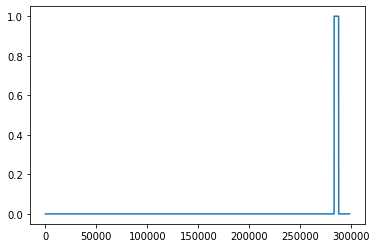

In [ ]:
group_df["Anomaly"].plot()

In [ ]:
corr_Anomaly = group_df.corr(method='pearson')["Anomaly"].abs()

In [ ]:
corr_Anomaly.sort_values(ascending=False)[1:16]

Stuck threads : (MXBean(com.bea:Name=ThreadPoolRuntime,Type=ThreadPoolRuntime).StuckThreadCount)                     0.856974
Stuck threads : (MXBean(com.bea:ApplicationRuntime=sys01,Name=default,Type=WorkManagerRuntime).StuckThreadCount)     0.856974
Connection delay : (MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).ConnectionDelayTime)                    0.500478
Connection delay : (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)                0.500478
Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)                0.479577
Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).ConnectionDelayTime)                    0.479577
Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)                0.468074
Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionDelayTime)                    0

In [ ]:
high_corr = corr_Anomaly.sort_values(ascending=False)[:30].index

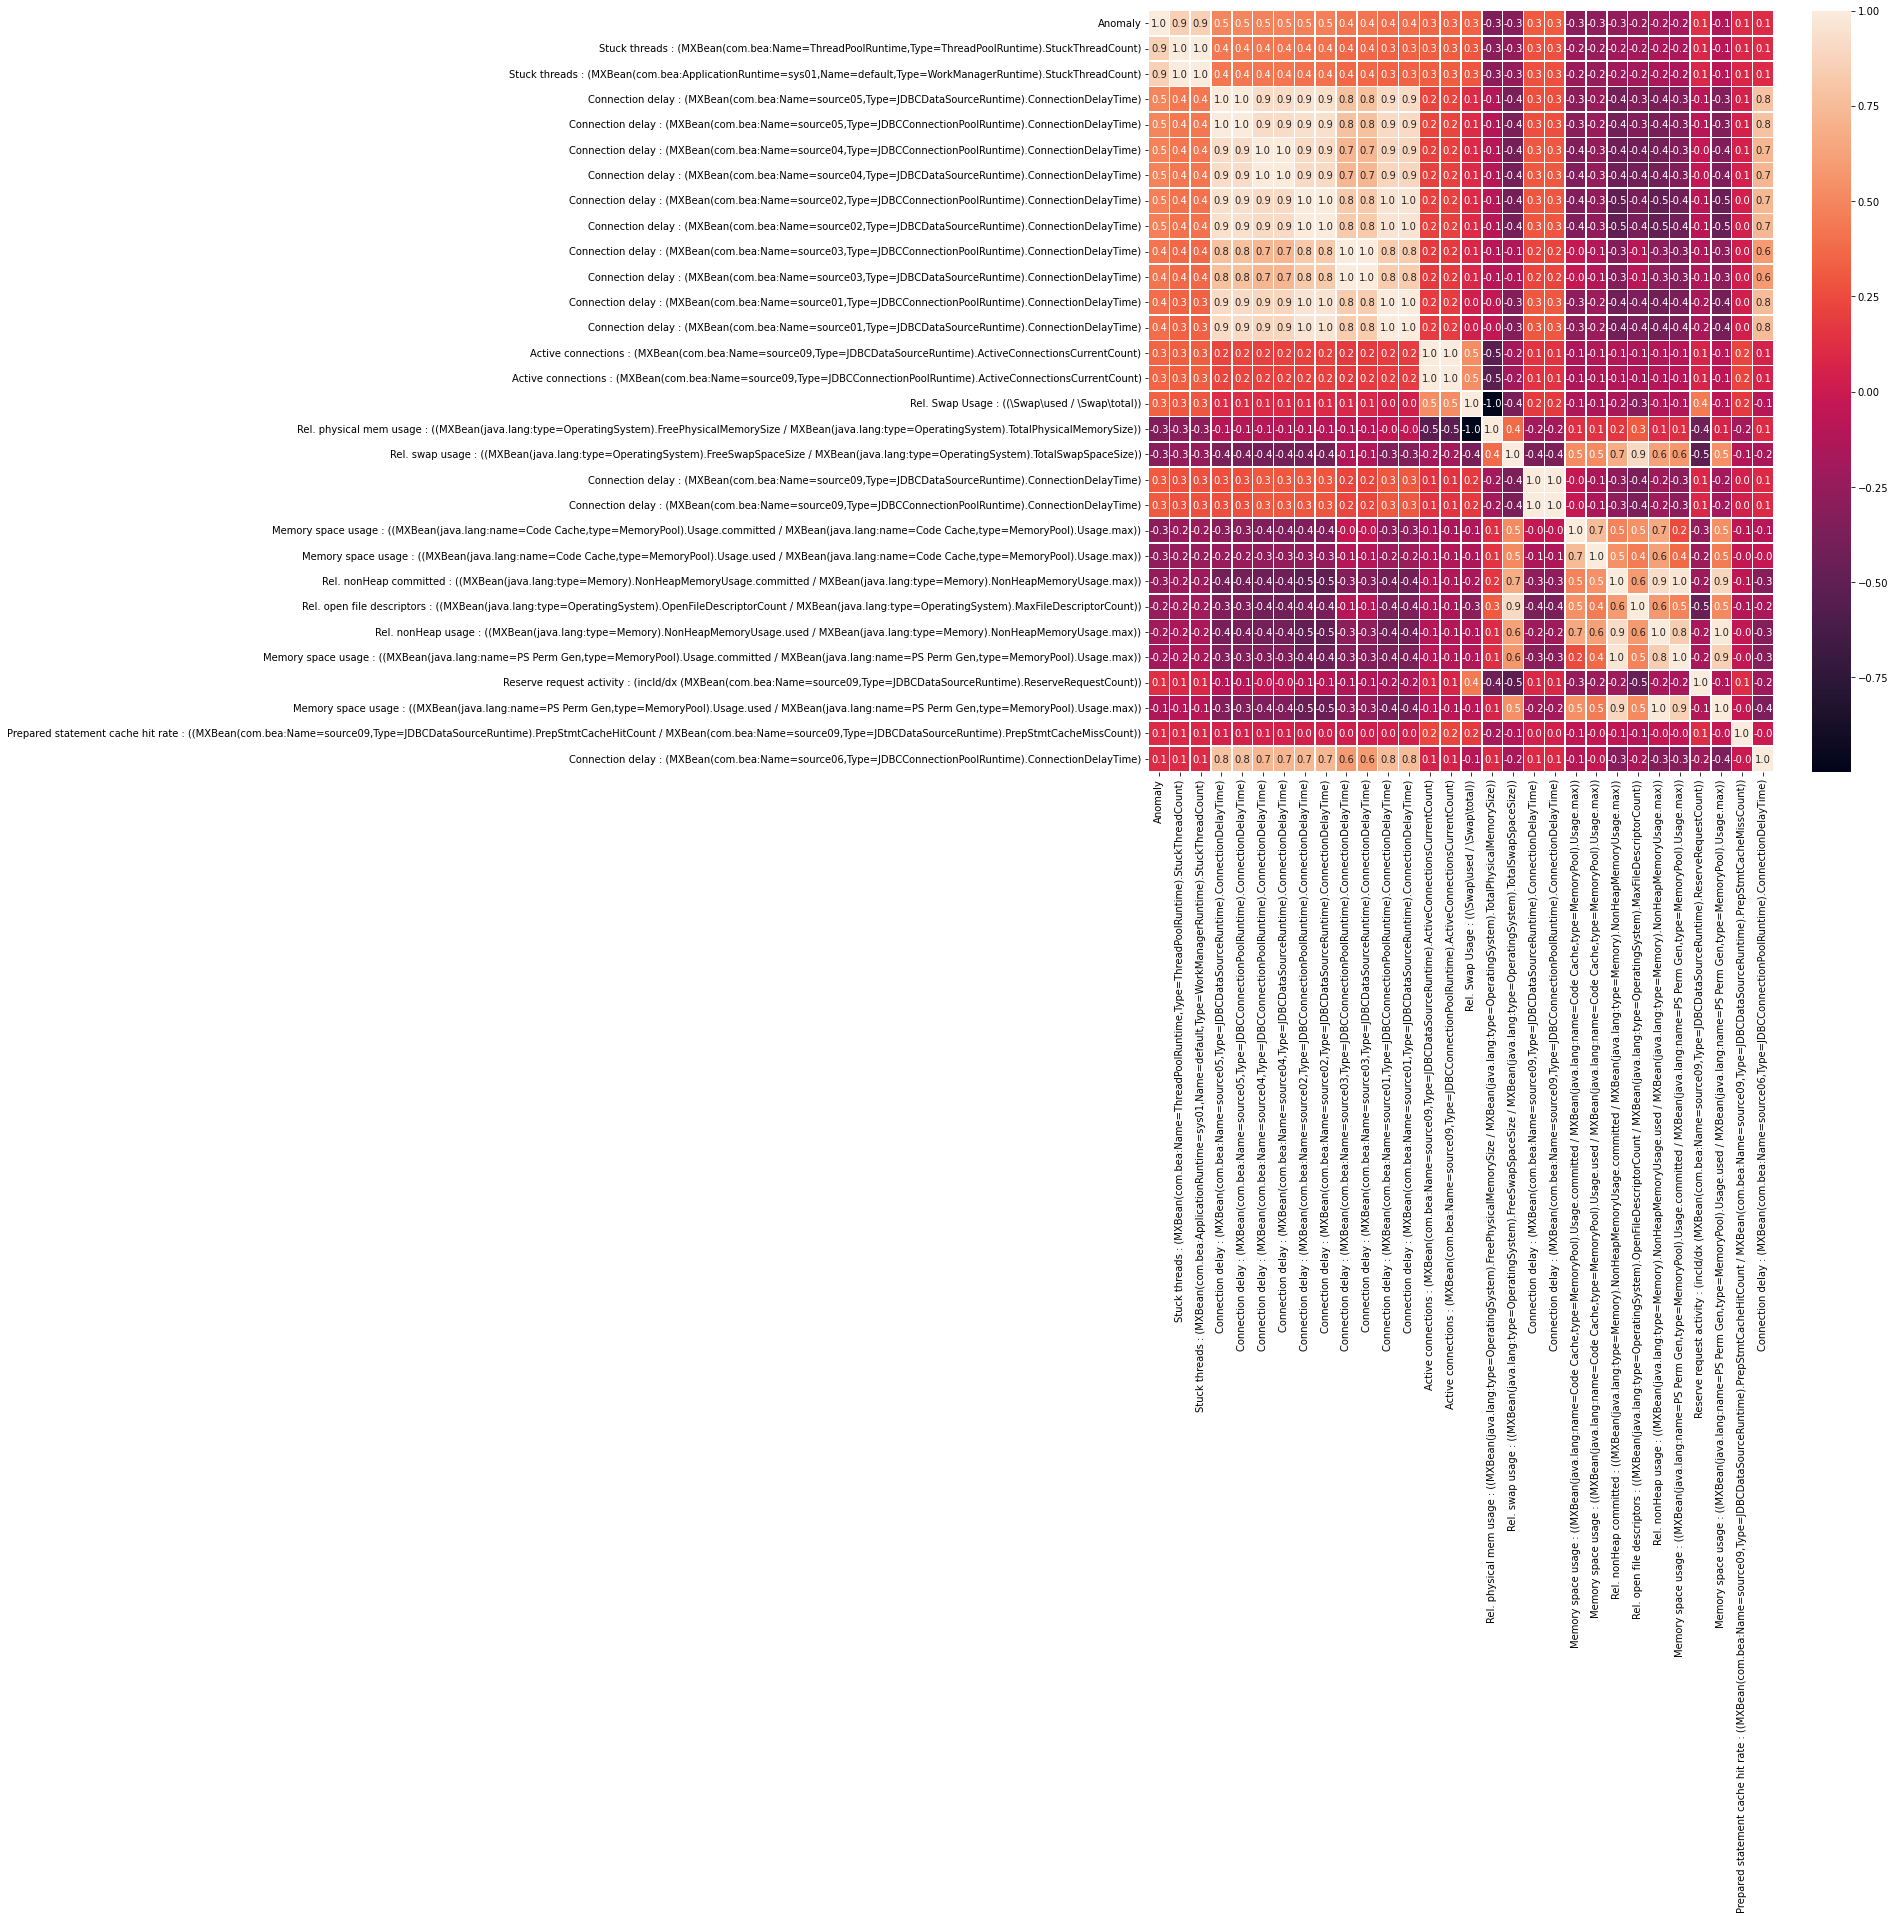

In [ ]:
df_ = group_df[high_corr]
dispname = [x.split(":")[0] for x in df_.columns.values]

f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(df_.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [ ]:
feature_cols = ['Anomaly',
    'Stuck threads : (MXBean(com.bea:Name=ThreadPoolRuntime,Type=ThreadPoolRuntime).StuckThreadCount)',
    'Connection delay : (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)',
    'Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).ConnectionDelayTime)',
    'Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionDelayTime)',
    'Connection delay : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)',
    'Connection delay : (MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).ConnectionDelayTime)',
    'Active connections : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)',
    'Rel. physical mem usage : ((MXBean(java.lang:type=OperatingSystem).FreePhysicalMemorySize / MXBean(java.lang:type=OperatingSystem).TotalPhysicalMemorySize))',
    'Rel. swap usage : ((MXBean(java.lang:type=OperatingSystem).FreeSwapSpaceSize / MXBean(java.lang:type=OperatingSystem).TotalSwapSpaceSize))',
    'Connection delay : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ConnectionDelayTime)',
    'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))',
    'Rel. open file descriptors : ((MXBean(java.lang:type=OperatingSystem).OpenFileDescriptorCount / MXBean(java.lang:type=OperatingSystem).MaxFileDescriptorCount))',
    'Memory space usage : ((MXBean(java.lang:name=PS Perm Gen,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Perm Gen,type=MemoryPool).Usage.max))',
    'Reserve request activity : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ReserveRequestCount))',
    'Memory space usage : ((MXBean(java.lang:name=PS Perm Gen,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Perm Gen,type=MemoryPool).Usage.max))',
    'Prepared statement cache hit rate : ((MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))',
]

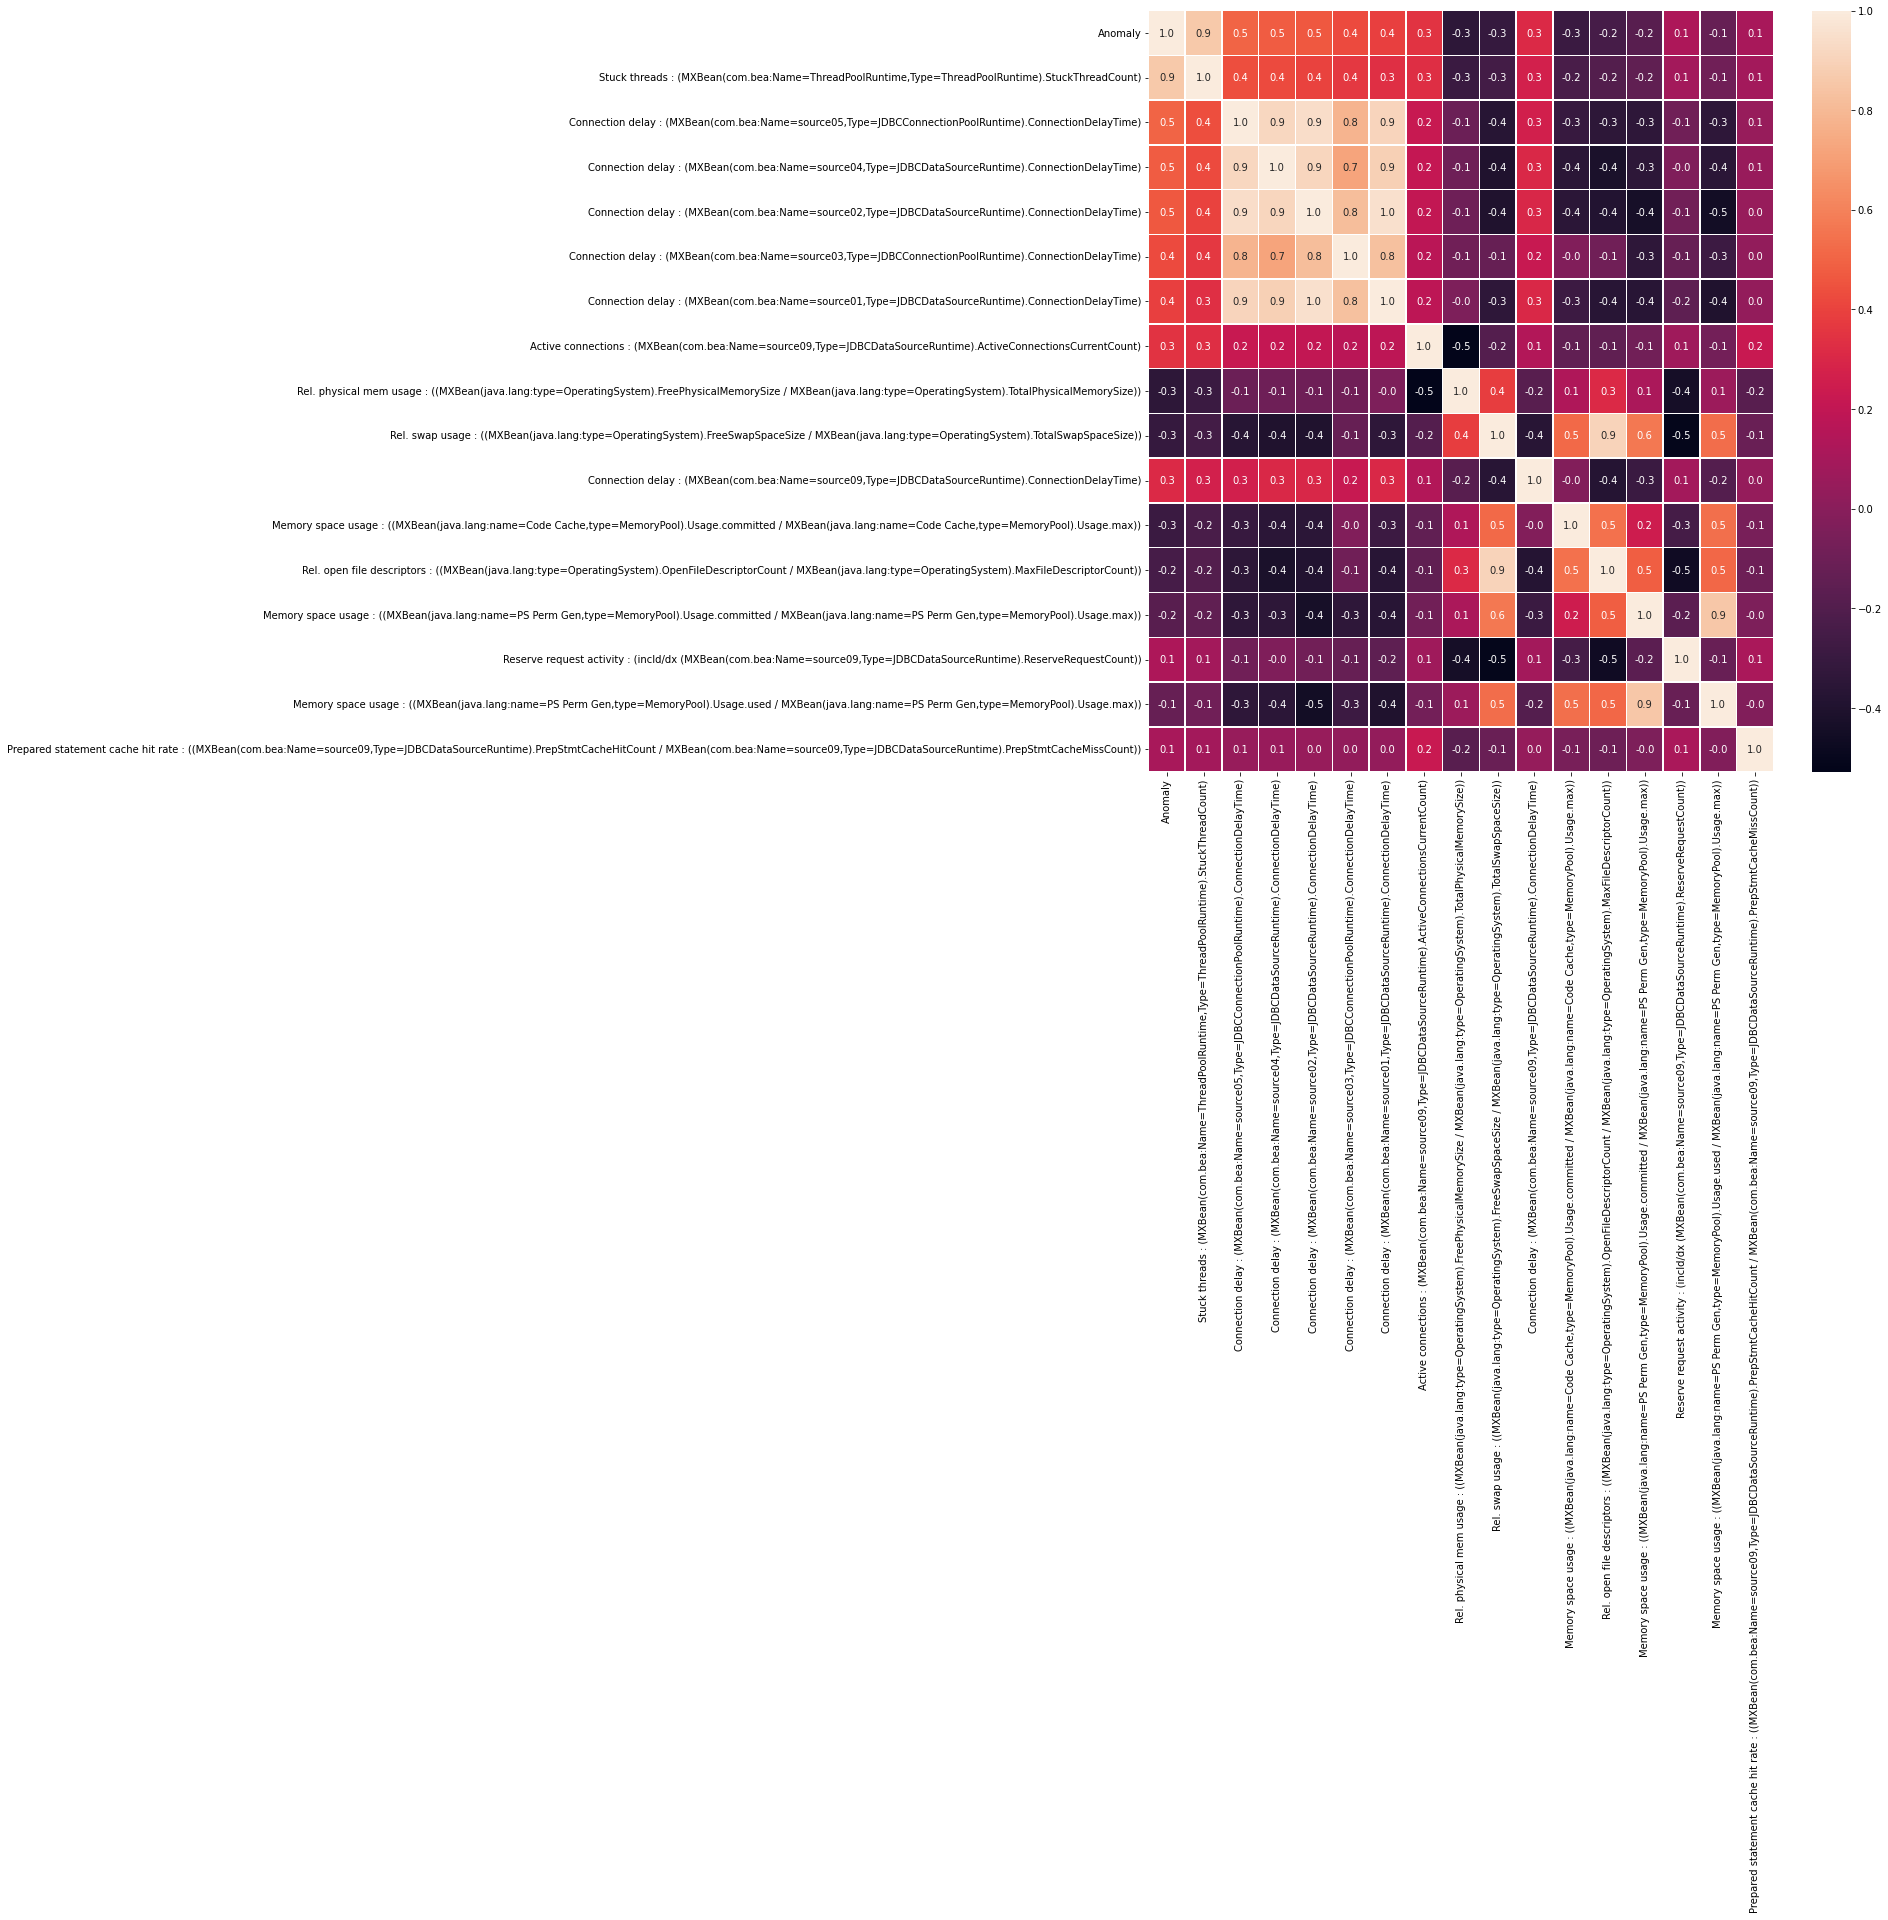

In [ ]:
df_ = group_df[feature_cols]
dispname = [x.split(":")[0] for x in df_.columns.values]

f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(df_.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [ ]:
filepath = "../output/summary.csv"
if not os.path.isfile(filepath):
        
    csv_len = []

    starttime = []
    endtime = []

    anonum = []
    rasingnum = []
    fallingnum = []

    rasingpos = []
    fallingpos = []

    for i, path in enumerate(tqdm(group_csvs[:])):
            
        tmp = pd.read_csv(path)

        csv_len.append(len(tmp))

        starttime.append(tmp["timestamp"].iloc[0])
        endtime.append(tmp["timestamp"].iloc[-1])

        if tmp["Anomaly"].value_counts()[0] == len(tmp):
            anonum.append(0)
            rasingnum.append(0)
            fallingnum.append(0)

            rasingpos.append([])
            fallingpos.append([])

        else:
            anonum.append( (tmp["Anomaly"]==True).sum() )
            raising,falling, rasingPos, fallingPos = isSeqencial_df(tmp, retPos=True)
            rasingnum.append(raising)
            fallingnum.append(falling)
        
            rasingpos.append(rasingPos)
            fallingpos.append(fallingPos)

    df_group_csvs = pd.DataFrame({
        "csvpath" : group_csvs,
        "csvlen" : csv_len,
        "starttime" : starttime,
        "endtime" : endtime,
        "anonum" : anonum,
        "rasingedgenum" : rasingnum,
        "fallingedgenum" : fallingnum,
        "rasingpos" : rasingpos,
        "fallingpos" : fallingpos,
    })
    df_group_csvs.to_csv(filepath, index=False)
else:
    df_group_csvs = pd.read_csv(filepath)
    import ast
    df_group_csvs["rasingpos"]  = df_group_csvs["rasingpos"].apply(lambda x:  [int(i) for i in ast.literal_eval(x)] )
    df_group_csvs["fallingpos"]  = df_group_csvs["fallingpos"].apply(lambda x:  [int(i) for i in ast.literal_eval(x)] )

In [ ]:
tmp = []

for i, row in tqdm(df_group_csvs.iterrows()):
    
    ano_block_num = row["rasingedgenum"]

    if ano_block_num > 0:
        df_tmp = pd.read_csv(row["csvpath"])
        for anostart, anoend in zip(row["rasingpos"], row["fallingpos"]):

            # 異常発生区間をdurationとして、異常発生前後から同じ区間のデータを取得する
            duration = anoend - anostart
            if anostart - duration > 0:
                start = anostart - duration
            else:
                start = 0
            if anoend + duration < len(df_tmp):
                end = anoend + duration
            else:
                end = len(df_tmp)

            tmp.append(df_tmp.loc[start:end, feature_cols])

all_data = pd.concat(tmp, axis=0).reset_index(drop=True)

0it [00:00, ?it/s]

In [ ]:
del df_tmp, tmp
gc.collect()

159

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = False)

all_data["fold"] = -1
for i, (_, idx) in enumerate(kf.split(all_data)):

    all_data.loc[idx, "fold"] = i

In [ ]:

train = all_data[all_data["fold"] == 0]
test = all_data[all_data["fold"] == 1]

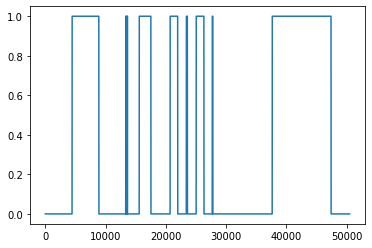

In [ ]:
train["Anomaly"].plot()

In [ ]:

CONFIG = {
    "exp_name" : "lstm_window15",
    "seed": 42,
    "epochs": 7,    
    "train_batch_size": 64,    
    "valid_batch_size": 128,    
    "learning_rate": 0.0001, 
    "scheduler": 'CosineAnnealingLR',    
    "min_lr": 0.000001,
    "n_fold": 5,    
    "num_classes": 1,    
    "num_workers": 2,    
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),    
}

In [ ]:
class TimeSeriseDataSet(Dataset):
    def __init__(self, data, N_FEAT, featurecols, window, targetcol=None , flag='TRAIN'):
        self.data = data
        self.n_feat = N_FEAT
        self.cols = featurecols
        self.target = targetcol
        self.flag = flag
        self.window = window

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):

        if self.flag == 'TRAIN':
            if idx > self.window:
                data = self.data[ self.cols ].iloc[idx-self.window: idx].values.astype(np.float32)
                y = self.data[ self.target ].iloc[idx].astype(np.float32) 
            else:
                data = self.data[ self.cols ].iloc[idx: idx+self.window].values.astype(np.float32)
                y = self.data[ self.target ].iloc[ self.window ].astype(np.float32) 
            return data, y
        else:
            if idx > self.window:
                data = self.data[ self.cols ].iloc[idx-self.window: idx].values.astype(np.float32)
                data = torch.from_numpy(data)
                data = data.to(device)                
            else:
                data = self.data[ self.cols ].iloc[idx: idx+self.window].values.astype(np.float32)
                data = torch.from_numpy(data)
                data = data.to(device) 
            return data

class TimeSeriseDataModule(LightningDataModule):

    def __init__(self, data, test_data, train_id, valid_id,feature_cols ,target_col ,window, N_FEAT, BS):
        super().__init__()

        self.data = data
        self.test_data = test_data
        self.train_id = train_id
        self.valid_id = valid_id
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.window = window

        self.BS = BS

        self.N_FEAT = N_FEAT

        #self.num_cores = os.cpu_count()

    def train_dataloader(self):

        train_ds = TimeSeriseDataSet(data=self.data.iloc[self.train_id,:], N_FEAT=self.N_FEAT, featurecols=self.feature_cols, targetcol=self.target_col, window=self.window,flag='TRAIN' )
        train_dl = DataLoader(train_ds, batch_size=self.BS,
                              shuffle=True, drop_last=False )
        return train_dl

    def val_dataloader(self):
        valid_ds = TimeSeriseDataSet(data=self.data.iloc[self.valid_id,:], N_FEAT=self.N_FEAT, featurecols=self.feature_cols, targetcol=self.target_col, window=self.window,flag='TRAIN')
        valid_dl = DataLoader(valid_ds, batch_size=self.BS,
                              shuffle=False, drop_last=False)
        return valid_dl

    def test_dataloader(self):
        test_ds = TimeSeriseDataSet(data=self.test_data, N_FEAT=self.N_FEAT, featurecols=self.feature_cols, flag='TEST', window=self.window)
        test_dl = DataLoader(test_ds, batch_size=self.BS,
                             shuffle=False)
        return test_dl


In [ ]:
def fetch_scheduler(optimizer):
    
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=CONFIG['T_max'],
            eta_min=CONFIG['min_lr']
        )
        
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=CONFIG['T_0'],
            eta_min=CONFIG['min_lr']
        )
        
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [ ]:
class RNNModel(LightningModule):
    def __init__(
        self,
        input_dim=16, 
        lstm_dim=256,
        dense_dim=256,
        logit_dim=256,
        num_classes=1,
    ):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, dense_dim // 2),
            nn.ReLU(),
            nn.Linear(dense_dim // 2, dense_dim),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(dense_dim, lstm_dim, batch_first=True, bidirectional=True)

        self.logits = nn.Sequential(
            nn.Linear(lstm_dim * 2, logit_dim),
            nn.ReLU(),
            nn.Linear(logit_dim, num_classes),
        )
        self.m = nn.Sigmoid()

    def forward(self, x):
        features = self.mlp(x)
        features, _ = self.lstm(features)
        pred = self.logits(features[:,-1])
        pred = self.m(pred)
        
        return pred[:,-1]

    def training_step(self, batch, batch_idx):
        
        x, targets = batch
        outputs = self(x)
        loss = self.criterion(outputs, targets)
        self.log("train_loss", loss, prog_bar=True, logger=True)

        return {"loss": loss}
    
    def validation_step(self, batch, batch_idx):
        x, targets = batch

        outputs = self(x)
        loss = self.criterion(outputs, targets)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return {'val_loss': loss}
        
    def configure_optimizers(self):
        
        optimizer = AdamW(self.parameters())
        scheduler = fetch_scheduler(optimizer)
        
        return dict(
            optimizer = optimizer,
            lr_scheduler = scheduler
        )

    def criterion(self, outputs, targets):
        loss = nn.BCELoss()
        return loss(outputs, targets)

In [ ]:
gc.enable()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# =========================================================
SEED = 2022

def preprocess_df(df_, df_test, N_FEAT, feature_cols):

    gc.collect()

    ss = StandardScaler()
    _ = ss.fit(df_.loc[:, feature_cols])

    data = df_.copy()
    data.loc[:, feature_cols] = ss.transform(data.loc[:, feature_cols])

    test_data = df_test.copy()
    test_data.loc[:,feature_cols] = ss.transform(test_data.loc[:, feature_cols])

    return data, test_data


cuda


In [ ]:
target_col = "Anomaly"
feature_cols = list(set(feature_cols) - set([target_col]))

train_df = train[feature_cols]
test_df = test[feature_cols]

N_FEAT = len(feature_cols)

data, test_data = preprocess_df(train_df, test_df, N_FEAT=N_FEAT, feature_cols=feature_cols)

data[target_col] = train[target_col]
test_data[target_col] = test[target_col]

In [ ]:
window=15

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import datetime
now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")

BS = CONFIG["train_batch_size"]

csv_logger = CSVLogger('/content/drive/MyDrive/python/cpt-softano/models/LSTM/logger', name='lstm', version='0'),

skf = StratifiedKFold(n_splits=2)
for i, (train_index, valid_index) in enumerate(i, skf.split(data, data["Anomaly"])):

    dm = TimeSeriseDataModule(data, test_data, train_index, valid_index, feature_cols, target_col, window, N_FEAT, BS)
    model = RNNModel( input_dim=N_FEAT )

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath="/content/drive/MyDrive/python/cpt-softano/models/LSTM/checkpoints/" + current_time,
        filename=f'fold{i}' + '-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        mode='min'
    )

    trainer = Trainer(
        logger=csv_logger,
        callbacks=[checkpoint_callback],
        max_epochs=10,
        gpus=-1,
        progress_bar_refresh_rate=30,
        default_root_dir="/content/drive/MyDrive/python/cpt-softano/models/"
    )

    trainer.fit(model, dm)


train_index: [23632 23633 23634 ... 50489 50490 50491] test_index: [    0     1     2 ... 37871 37872 37873]
train_index: 25246 test_index: 25246


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Experiment logs directory /content/drive/MyDrive/python/cpt-softano/models/LSTM/logger/lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are s

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | mlp    | Sequential | 35.2 K
1 | lstm   | LSTM       | 1.1 M 
2 | logits | Sequential | 131 K 
3 | m      | Sigmoid    | 0     
--------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.878     Total estimated model params size (MB)


train_index: [    0     1     2 ... 37871 37872 37873] test_index: [23632 23633 23634 ... 50489 50490 50491]
train_index: 25246 test_index: 25246


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/MyDrive/python/cpt-softano/models/LSTM/checkpoints/2022-02-01-04-43 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]